In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 12

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: scheduler='tcp://10.148.1.19:57938' processes=60 cores=240>

# Read dataset

In [5]:
E_dir = '/home1/scratch/xyu/momentum/'

In [6]:
D = [xr.open_zarr(E_dir+'Coriolis_u_linear_f%02d.nc'%(face)).rename({'i_g': 'i'}) for face in range(13)]
ds_Coriolis = xr.concat(D, dim='face')
D = [xr.open_zarr(E_dir+'dB_dx_geo_f%02d.nc'%(face)).rename({'i_g': 'i'}) for face in range(13)]
ds_B = xr.concat(D, dim='face')

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid.nc')

%time ds = xr.merge([ds_Coriolis,ds_B,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.57 ms
<xarray.Dataset>
Dimensions:            (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 720)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time               (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
  * face               (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g                (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * j_g                (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    XC                 (face, j, i) float32 ...
    YC                 (face, j, i) float32 ...
    XG                 (face, j_g, i_g) float32 ...
    YG                 (face, j_g, i_g) float32 ...
    CS                 (face, j, i) float32 ...
    SN                 (face, j, i) float32 ...
    rA                 (face, j, i) float32 ...
    dxG  

In [7]:
lat = ds['YC']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))

#### geostrophy metric : (fv-g*dEta/dx)/fv

In [7]:
geo_error = (ds['Coriolis_u_linear'] - ds['dB_dx_geo'])/ds['Coriolis_u_linear']
print(geo_error)

<xarray.DataArray (face: 13, j: 4320, i: 4320, time: 720)>
dask.array<shape=(13, 4320, 4320, 720), dtype=float32, chunksize=(1, 4320, 4320, 1)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) float32 -114.93228 -114.93217 -114.93205 ...
    YC       (face, j, i) float32 -88.17715 -88.18007 -88.18299 -88.185905 ...
    CS       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SN       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rA       (face, j, i) float32 155492.97 155503.03 155513.17 155523.31 ...
    Depth    (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


In [ ]:
for face in range(ds['face'].size):

    geo_error = (ds['Coriolis_u_linear'] - ds['dB_dx_geo'])/ds['Coriolis_u_linear']
    geo_error = np.real(geo_error).rename('geo_error').sel(face=face)  
    geo_error = geo_error.chunk({'time': 1,'i_g':4320,'j':4320})
    geo_error.to_dataset().to_zarr(E_dir+'geo_error_f%02d.nc'% (face), mode='w')
    print('face=%d - allready processed'%(face))

In [9]:
geo_error_log = np.log10(np.abs(geo_error)).persist()

In [10]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.12:49803 remote=tcp://10.148.1.12:52059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.12:52656 remote=tcp://10.148.1.12:52059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.12:54987 remote=tcp://10.148.1.12:52059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.12:54989 remote=tcp://10.148.1.12:52059>


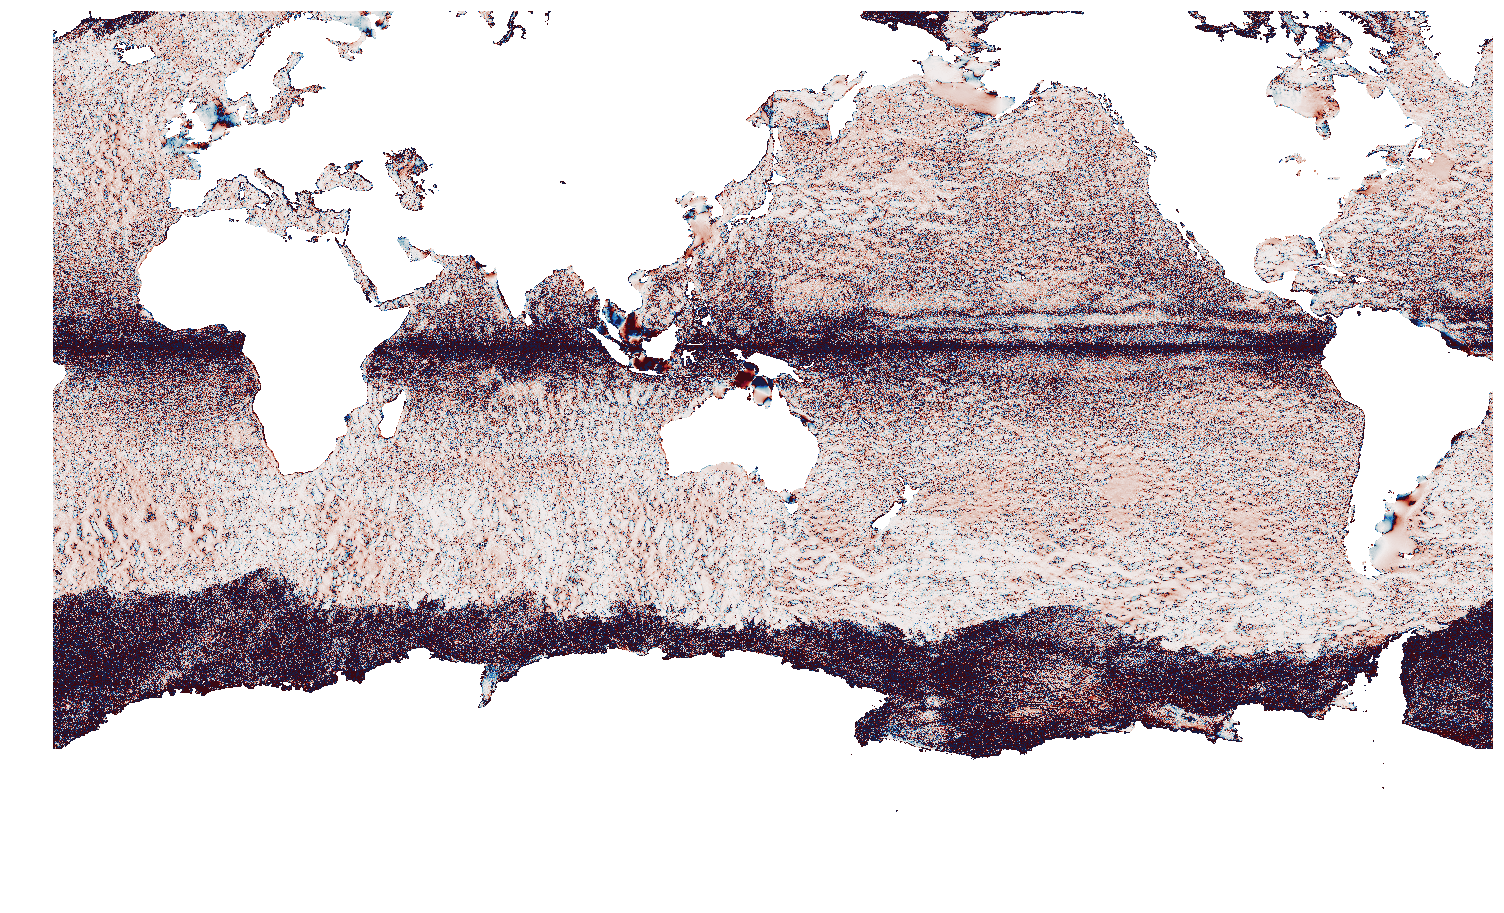

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.12:33713 remote=tcp://10.148.1.12:52059>


In [31]:
quick_llc_plot(geo_error.isel(time=80), vmin=-10., vmax=10., add_colorbar=False, axis_off=True, cmap = cm.balance)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.12:43506 remote=tcp://10.148.1.12:37680>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.12:43507 remote=tcp://10.148.1.12:37680>


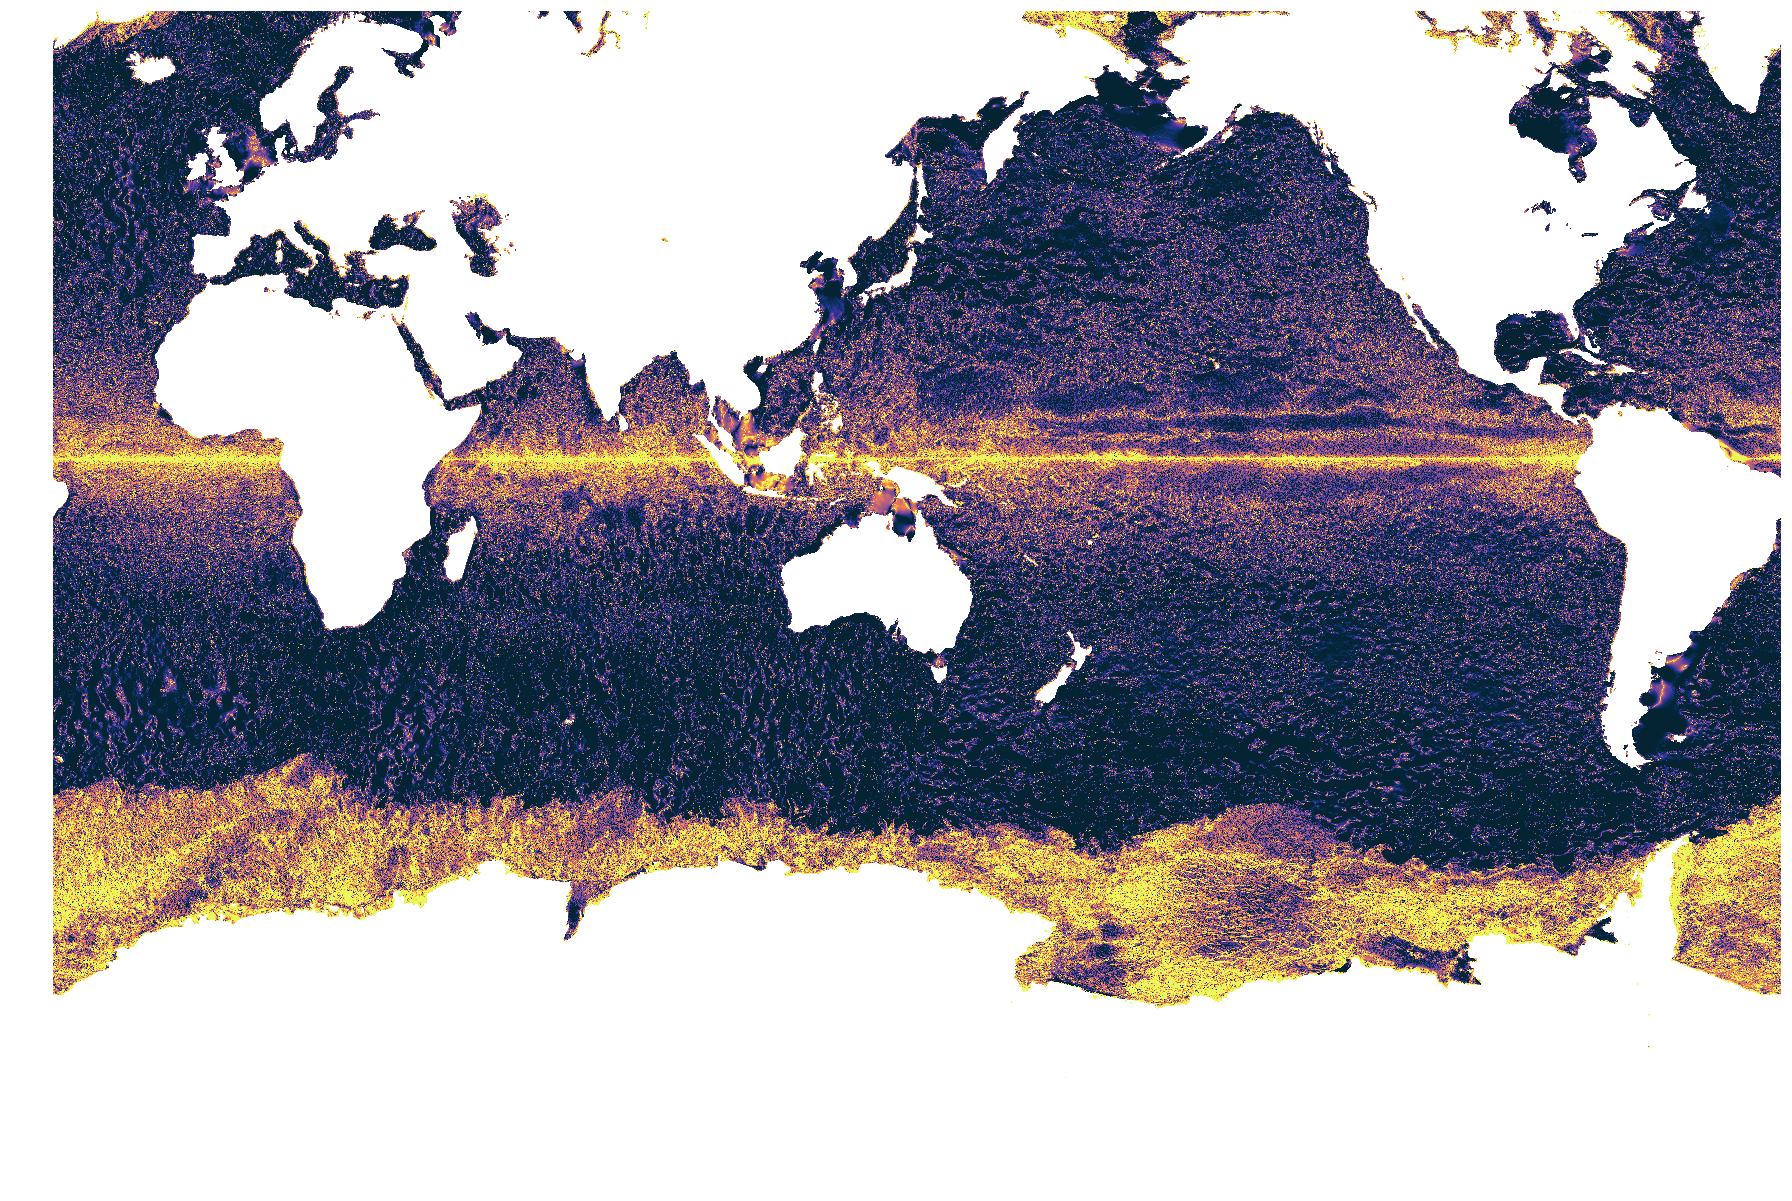

In [12]:
geo_error_log_80 = geo_error_log.isel(time=80)
quick_llc_plot(geo_error_log.isel(time=80), vmin=0., vmax=2., add_colorbar=False, axis_off=True, cmap = cm.thermal)

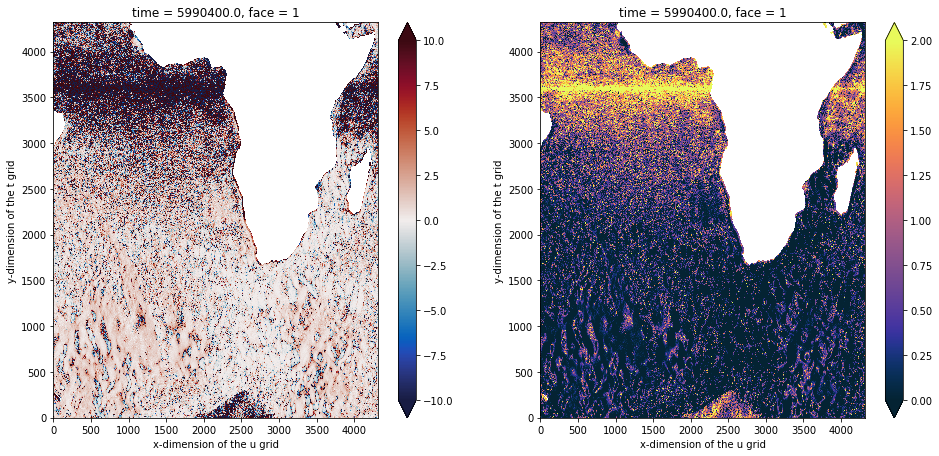

In [23]:
face_plot = 1

fig = plt.figure(figsize = (16,16))

plt.subplot(221)
geo_error.isel(face= face_plot,time=80).load().plot(vmin=-10, vmax=10, cmap = cm.balance)
plt.subplot(222)
geo_error_log.isel(face= face_plot,time=80).load().plot(vmin=0, vmax=2, cmap = cm.thermal)


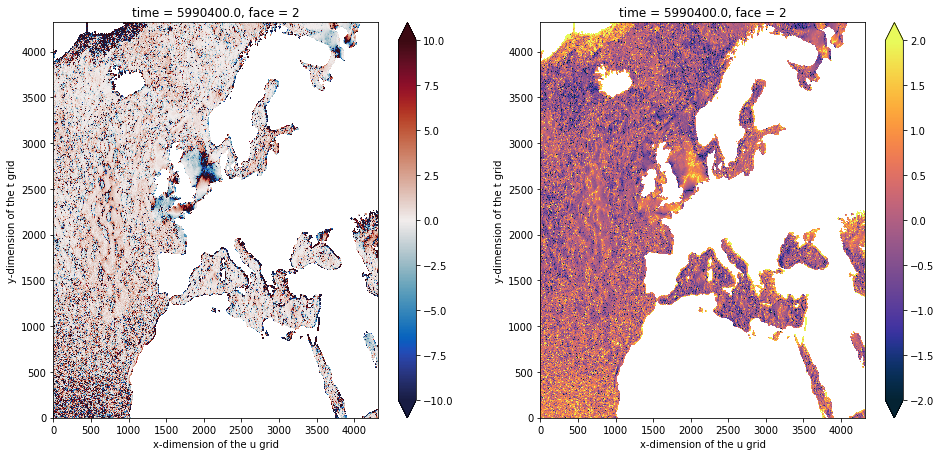

In [21]:
face_plot = 2

fig = plt.figure(figsize = (16,16))

plt.subplot(221)
geo_error.isel(face= face_plot,time=80).load().plot(vmin=-10, vmax=10, cmap = cm.balance)
plt.subplot(222)
geo_error_log.isel(face= face_plot,time=80).load().plot(vmin=-2, vmax=2, cmap = cm.thermal)


In [ ]:
face_plot = 2

fig, ax = plt.subplots(figsize=(24,12))
labels = ['0','1']

geo_error.isel(face=face_plot,i=500,j=2000).load().plot(ax=ax, label=labels[0])

ax.legend(); ax.grid()
#ax.set_xlim([0,480])
ax.set_ylim([-100,100])

In [39]:
# rms^2
geo_error_rms = (geo_error**2).mean(['time']).load()

In [43]:
geo_error_rms_log = np.log10(geo_error_rms).persist()

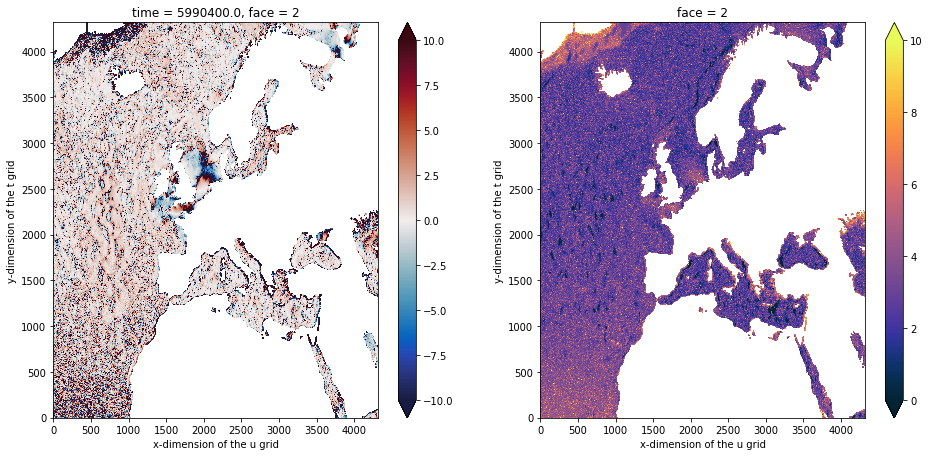

In [44]:
face_plot = 2

fig = plt.figure(figsize = (16,16))

plt.subplot(221)
geo_error.isel(face= face_plot,time=80).load().plot(vmin=-10, vmax=10, cmap = cm.balance)
plt.subplot(222)
geo_error_rms_log.isel(face= face_plot).load().plot(vmin=0, vmax=10, cmap = cm.thermal)



In [ ]:
quick_llc_plot(geo_error_rms_log, vmin=0., vmax=10., add_colorbar=False, axis_off=True, cmap = cm.thermal)

In [23]:
cluster.scheduler.close()

<Future finished result=None>